<a href="https://www.kaggle.com/code/burakaka/brain-tumor-classification?scriptVersionId=213928206" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Rescaling,Dense,RandomTranslation,RandomBrightness,RandomWidth,RandomHeight,RandomContrast, Conv2D,Input, MaxPooling2D, Flatten, GlobalAveragePooling2D,Dropout,Rescaling,RandomFlip,RandomRotation,RandomZoom,Reshape
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB7
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall


In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping


checkpoint = ModelCheckpoint(
    filepath='best_model_efficientnetb7.keras',  
    monitor='val_accuracy',       
    save_best_only=True,       
    mode='max',                
    verbose=1
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',      
    factor=0.5,
    patience=3,
    min_lr=1e-6,              
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True,
    verbose=1
)


**IMAGE PREPROCESSING**

In [1]:
import os
files=os.listdir("/kaggle/input/brain-tumor-mri-data/brain-tumor-mri-dataset/glioma")

In [2]:
len(files)

1621

In [6]:
import cv2
import matplotlib.pyplot as plt

In [4]:
img_list=list()
for i in files[:20]:
  img=cv2.imread("/kaggle/input/brain-tumor-mri-data/brain-tumor-mri-dataset/glioma/"+i)
  img=cv2.resize(img,(400,400))
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img_list.append(img)

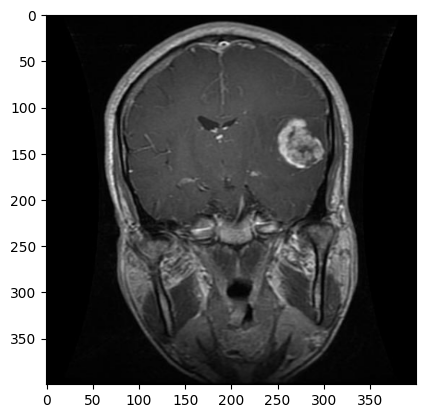

In [5]:
plt.imshow(img_list[18])

In [6]:
copied_file=img_list[15].copy()

In [7]:
copied_file=cv2.cvtColor(copied_file,cv2.COLOR_RGB2GRAY)

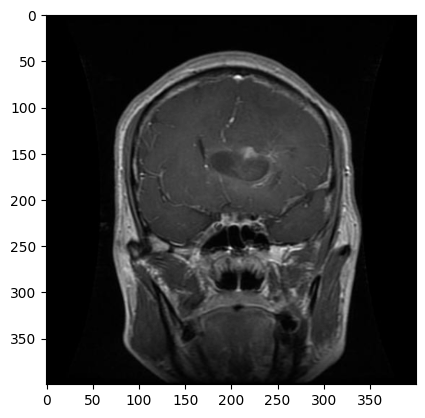

In [8]:
plt.imshow(copied_file,cmap="gray")

In [9]:
thresh=cv2.threshold(copied_file,16,255,cv2.THRESH_BINARY)

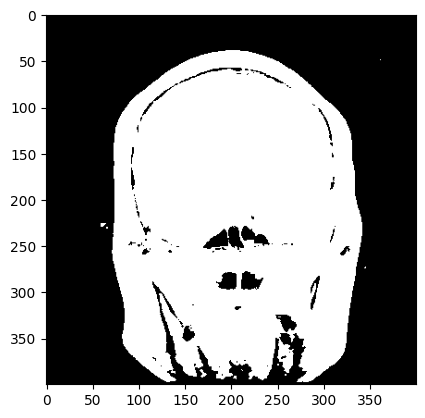

In [10]:
plt.imshow(thresh[1],cmap="gray")

In [11]:
blur=cv2.GaussianBlur(copied_file,(25,25),0)

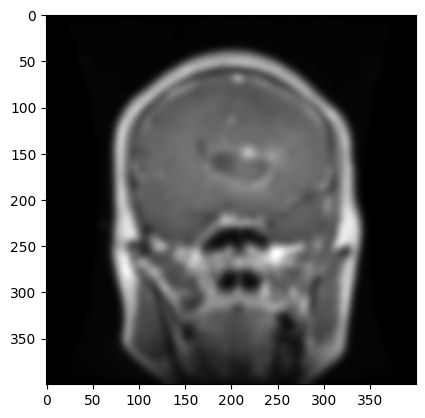

In [12]:
plt.imshow(blur,cmap="gray")

In [13]:
thresh=cv2.threshold(blur,7,255,cv2.THRESH_BINARY)

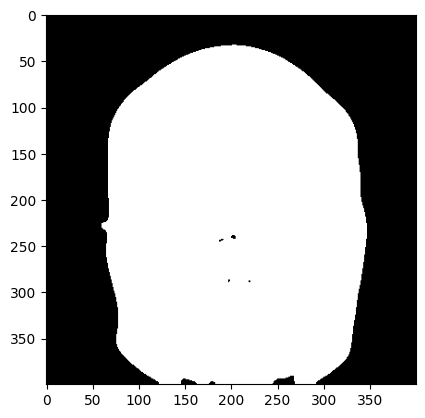

In [14]:
plt.imshow(thresh[1],cmap="gray")

In [15]:
contour,_=cv2.findContours(thresh[1],cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

In [16]:
contour

(array([[[201,  33]],
 
        [[200,  34]],
 
        [[199,  34]],
 
        ...,
 
        [[204,  33]],
 
        [[203,  33]],
 
        [[202,  33]]], dtype=int32),)

In [17]:
len(contour[0])

1041

In [18]:
contour=contour[0]

In [19]:
contour.shape

(1041, 1, 2)

In [20]:
contour=contour[:,0,:]

In [21]:
contour.shape

(1041, 2)

In [22]:
contour[:,0].argmax()

781

In [23]:
left=contour[contour[:,0].argmin()]
right=contour[contour[:,0].argmax()]
top=contour[contour[:,1].argmin()]
bottom=contour[contour[:,1].argmax()]

In [24]:
x1=left[0]
y1=top[1]
x2=right[0]
y2=bottom[1]

In [25]:
crop_ilk=img_list[15].copy()[y1:y2,x1:x2]

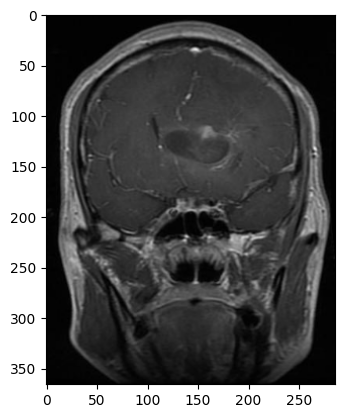

In [26]:
plt.imshow(crop_ilk)

In [27]:
crop_ilk.shape

(366, 286, 3)

In [28]:
crop_ilk=cv2.resize(crop_ilk,(400,400))

In [29]:
crop_ilk.shape

(400, 400, 3)

In [30]:
x=(x2-x1)*4//100
y=(y2-y1)*5//100

In [31]:
x

11

In [32]:
y

18

In [33]:
crop_ilk=img_list[15].copy()[y1+y:y2-y,x1+x:x2-x]
crop_ilk=cv2.resize(crop_ilk,(400,400))

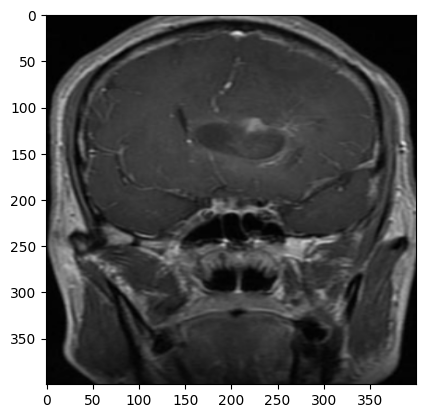

In [34]:
plt.imshow(crop_ilk)

In [35]:
lab=cv2.cvtColor(img_list[18],cv2.COLOR_RGB2LAB)

In [36]:
l,a,b=cv2.split(lab)

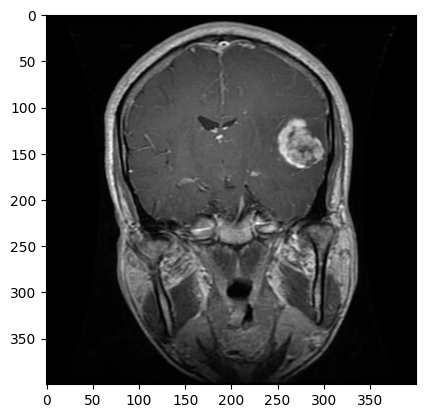

In [37]:
plt.imshow(l,cmap="gray")

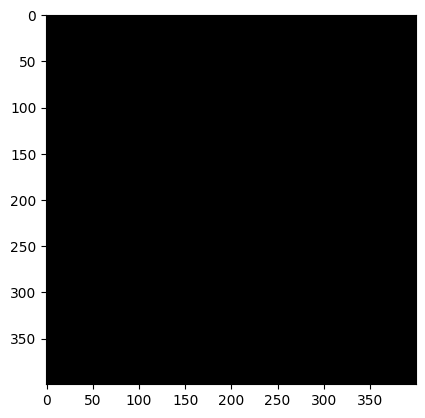

In [38]:
plt.imshow(a,cmap="gray")

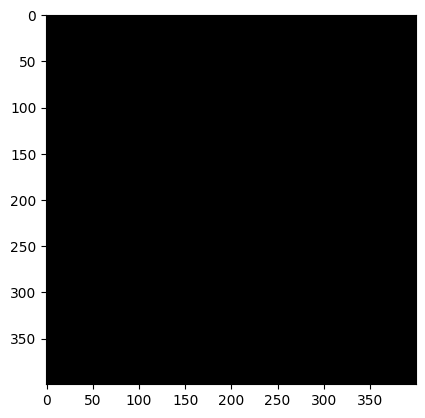

In [39]:
plt.imshow(b,cmap="gray")

In [40]:
flatten=l.flatten()

In [41]:
flatten.shape

(160000,)

(array([7.3335e+04, 3.0500e+03, 2.8680e+03, 3.1780e+03, 4.0900e+03,
        7.5290e+03, 1.3229e+04, 1.3926e+04, 1.4214e+04, 5.4780e+03,
        4.3860e+03, 3.0380e+03, 3.1190e+03, 2.4190e+03, 1.9240e+03,
        1.7810e+03, 9.4700e+02, 6.5200e+02, 3.2500e+02, 2.1900e+02,
        1.5300e+02, 7.1000e+01, 4.6000e+01, 2.3000e+01, 0.0000e+00]),
 array([  0. ,  10.2,  20.4,  30.6,  40.8,  51. ,  61.2,  71.4,  81.6,
         91.8, 102. , 112.2, 122.4, 132.6, 142.8, 153. , 163.2, 173.4,
        183.6, 193.8, 204. , 214.2, 224.4, 234.6, 244.8, 255. ]),
 <BarContainer object of 25 artists>)

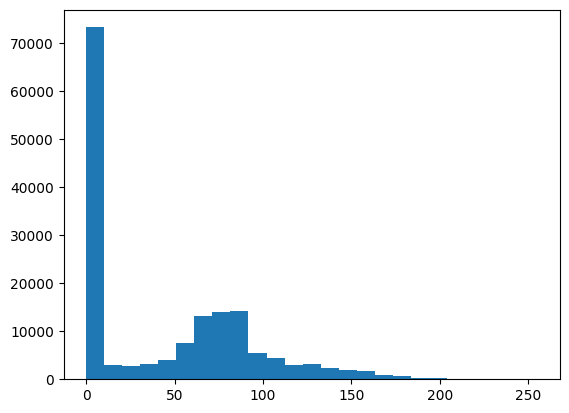

In [42]:
plt.hist(flatten,25,[0,255])

In [43]:
clahe=cv2.createCLAHE(clipLimit=7.0,tileGridSize=(8,8))

In [44]:
clahe=clahe.apply(l)

(array([37674., 16099., 16156.,  6479.,  3888.,  4258.,  3977.,  4324.,
         4696.,  4800.,  5407.,  5499.,  5631.,  5457.,  5145.,  5217.,
         4581.,  3783.,  3494.,  2957.,  3088.,  2492.,  2157.,  1612.,
         1129.]),
 array([  0. ,  10.2,  20.4,  30.6,  40.8,  51. ,  61.2,  71.4,  81.6,
         91.8, 102. , 112.2, 122.4, 132.6, 142.8, 153. , 163.2, 173.4,
        183.6, 193.8, 204. , 214.2, 224.4, 234.6, 244.8, 255. ]),
 <BarContainer object of 25 artists>)

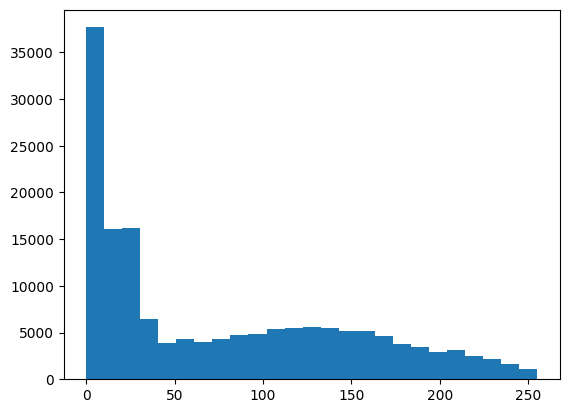

In [45]:
plt.hist(clahe.flatten(),25,[0,255])

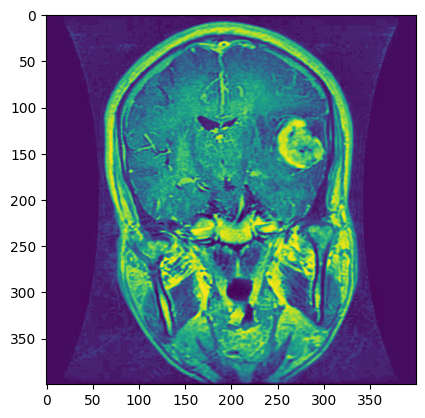

In [46]:
plt.imshow(clahe)

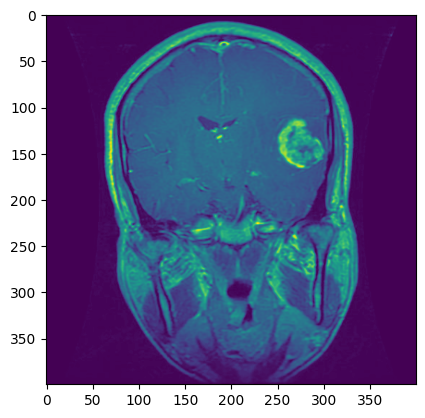

In [47]:
plt.imshow(l)

In [48]:
merged_image=cv2.merge((clahe,a,b))

In [49]:
final=cv2.cvtColor(merged_image,cv2.COLOR_LAB2RGB)

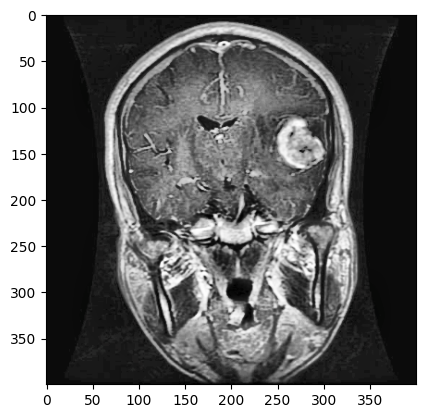

In [50]:
plt.imshow(final)

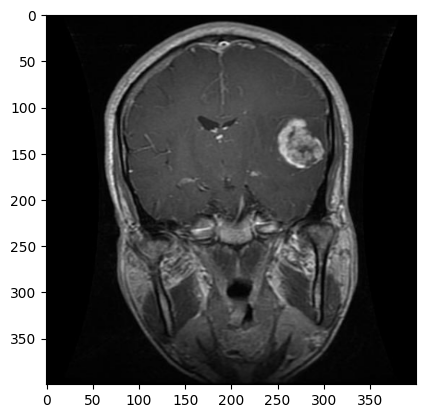

In [51]:
plt.imshow(img_list[18])

In [52]:
med_blur=cv2.medianBlur(final,3)

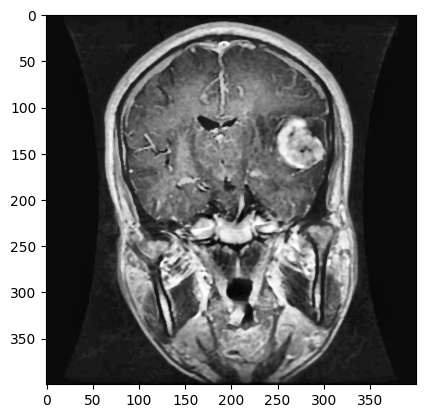

In [53]:
plt.imshow(med_blur)

In [54]:
background=cv2.medianBlur(final,39)

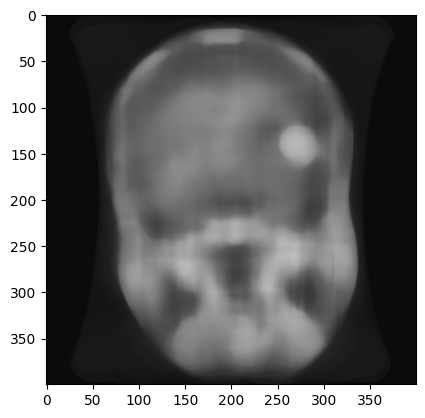

In [55]:
plt.imshow(background)

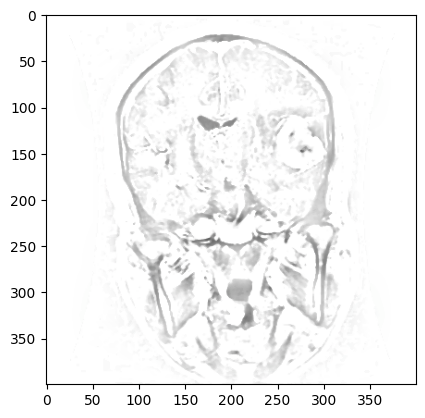

In [56]:
mask=cv2.addWeighted(med_blur,1,background,-1,255)
plt.imshow(mask)

In [57]:
final_img=cv2.bitwise_and(med_blur,mask)

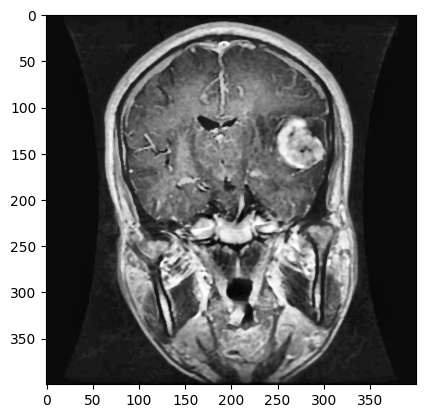

In [58]:
plt.imshow(med_blur)

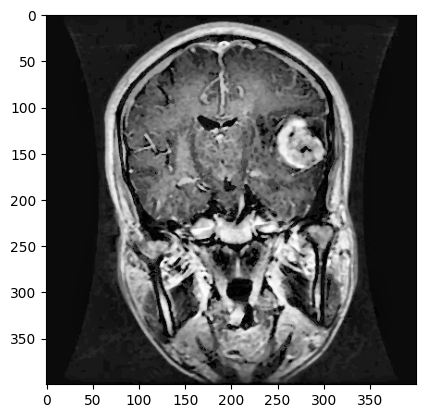

In [59]:
plt.imshow(final_img)

In [43]:
import warnings

warnings.filterwarnings("ignore")


In [3]:
from tqdm import tqdm
import os
import numpy as np
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf





def preprocess_images(train_dir):
    class_names = os.listdir(train_dir)  
    class_names.sort()
    img_list_preprocess = []
    labels = []
    
    for label, class_name in enumerate(class_names):  
        class_dir = os.path.join(train_dir, class_name)
        files = os.listdir(class_dir)
        
        for i in tqdm(files):
            img = cv2.imread(os.path.join(class_dir, i)) 
            img=cv2.resize(img,(400,400))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            copied_file=img.copy()
            copied_file=cv2.cvtColor(copied_file,cv2.COLOR_RGB2GRAY)
            blur=cv2.GaussianBlur(copied_file,(25,25),0)
            thresh=cv2.threshold(blur,7,255,cv2.THRESH_BINARY)
            contour,_=cv2.findContours(thresh[1],cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
            contour=contour[0]
            contour=contour[:,0,:]
            left=contour[contour[:,0].argmin()]
            right=contour[contour[:,0].argmax()]
            top=contour[contour[:,1].argmin()]
            bottom=contour[contour[:,1].argmax()]
            x1=left[0]
            y1=top[1]
            x2=right[0]
            y2=bottom[1]
            
            x=(x2-x1)*4//50
            y=(y2-y1)*5//50
            if x2-x1>100 and y2-y1>100:
                crop_ilk=img.copy()[y1+y:y2-y,x1+x:x2-x]
                crop_ilk=cv2.resize(crop_ilk,(400,400))
                lab=cv2.cvtColor(crop_ilk,cv2.COLOR_RGB2LAB)
                l,a,b=cv2.split(lab)
                clahe=cv2.createCLAHE(clipLimit=7.0,tileGridSize=(8,8))
                clahe=clahe.apply(l)
                merged_image=cv2.merge((clahe,a,b))
                final=cv2.cvtColor(merged_image,cv2.COLOR_LAB2RGB)
                med_blur=cv2.medianBlur(final,3)
                background=cv2.medianBlur(final,37)
                mask=cv2.addWeighted(med_blur,1,background,-1,255)
                final_img=cv2.bitwise_and(med_blur,mask)
                
                img_list_preprocess.append(final_img) 
                labels.append(label)  

    return np.array(img_list_preprocess), np.array(labels)

In [4]:
train_dir="/kaggle/input/brain-tumor-mri-data/brain-tumor-mri-dataset"
processed_images, labels = preprocess_images(train_dir)


100%|██████████| 1757/1757 [00:27<00:00, 64.37it/s]


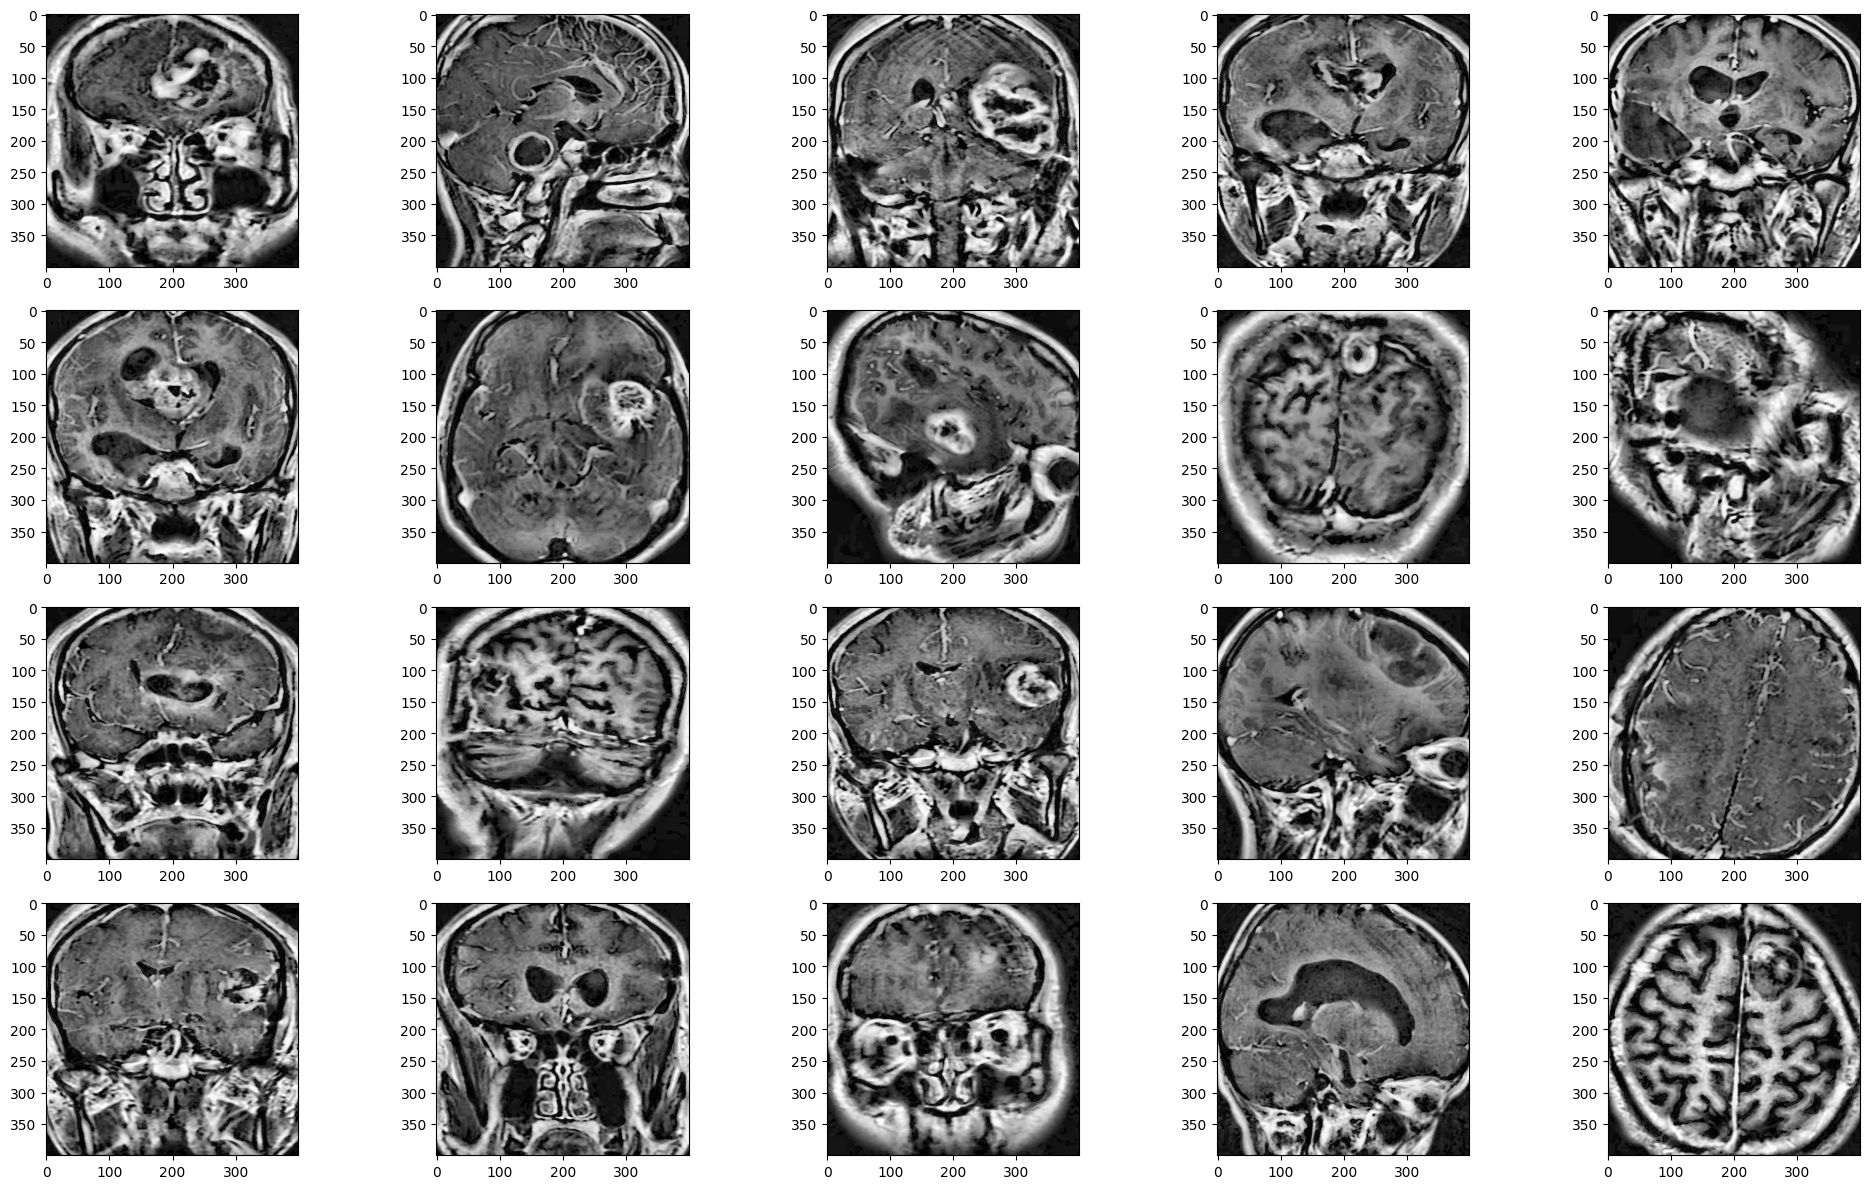

In [7]:
fig=plt.figure(figsize=(20,12))
for i in range(20):
  img=processed_images[i]
  fig.add_subplot(4,5,1+i)
  plt.imshow(img)
plt.tight_layout()

In [14]:
processed_images.shape

(4272, 400, 400, 3)

In [15]:
labels.shape

(4272,)

In [16]:
labels

array([0, 0, 0, ..., 3, 3, 3])

In [17]:
import pandas as pd


In [18]:
pd.DataFrame({"labels":labels}).value_counts()

labels
2         1648
0         1142
1          863
3          619
Name: count, dtype: int64

In [19]:
print("Labels: ", np.unique(labels))  # Farklı etiketleri kontrol et


Labels:  [0 1 2 3]


In [20]:
X_train, X_val, y_train, y_val = train_test_split(processed_images, labels, test_size=0.2, random_state=42, shuffle=True)


In [23]:
y_train.shape

(3417, 1)

In [22]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)


In [24]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [25]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=32)

In [30]:
base_model_final = EfficientNetB7(
    input_shape=(400,400, 3),  
    include_top=False,         
    weights='imagenet'         
)

In [31]:
len(base_model_final.layers)

814

In [32]:
for layer in base_model_final.layers[:805]:  
    layer.trainable = False

In [33]:
model = Sequential([
    InputLayer(shape=(400,400,3)),
# Veri artırma
    base_model_final,  
    GlobalAveragePooling2D(),  
    Dense(1024, activation='relu'),  
    Dropout(0.3),
    Dense(4, activation='softmax')  
])

In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 13, 13, 2560)   │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,622,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,724,251 (254.53 MB)

 Trainable params: 7,347,204 (28.03 MB)

 Non-trainable params: 59,377,047 (226.51 MB)

In [41]:
model.compile(
    optimizer="adam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[checkpoint,reduce_lr,early_stopping]  
)


Epoch 1/100
 14/107 ━━━━━━━━━━━━━━━━━━━━ 1:22 882ms/step - accuracy: 0.6826 - loss: 0.7642

2024-12-19 21:08:22.224314: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[25,192,100,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,192,201,201]{3,2,1,0}, f32[192,1,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, feature_group_count=192, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-19 21:08:22.689942: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.465764297s
Trying algorithm eng4{} for conv (f32[25,192,100,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,192,201,201]{3,2,1,0}, f32[192,1,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, feature_group_count=192, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","w

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8019 - loss: 0.5093

2024-12-19 21:11:21.154687: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[23,192,100,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,192,201,201]{3,2,1,0}, f32[192,1,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, feature_group_count=192, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-19 21:11:21.539937: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.38537498s
Trying algorithm eng4{} for conv (f32[23,192,100,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,192,201,201]{3,2,1,0}, f32[192,1,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, feature_group_count=192, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wa


Epoch 1: val_accuracy improved from -inf to 0.91345, saving model to best_model_efficientnetb7.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.8023 - loss: 0.5081 - val_accuracy: 0.9135 - val_loss: 0.2385 - learning_rate: 0.0010
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.9251 - loss: 0.1936
Epoch 2: val_accuracy did not improve from 0.91345
107/107 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9251 - loss: 0.1935 - val_accuracy: 0.8959 - val_loss: 0.3009 - learning_rate: 0.0010
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.9481 - loss: 0.1333
Epoch 3: val_accuracy improved from 0.91345 to 0.94035, saving model to best_model_efficientnetb7.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9482 - loss: 0.1332 - val_accuracy: 0.9404 - val_loss: 0.1533 - learning_rate: 0.0010
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.9595 - loss: 0.1069
Epoch 4: val_accuracy improved from 0.94035 to 0.9

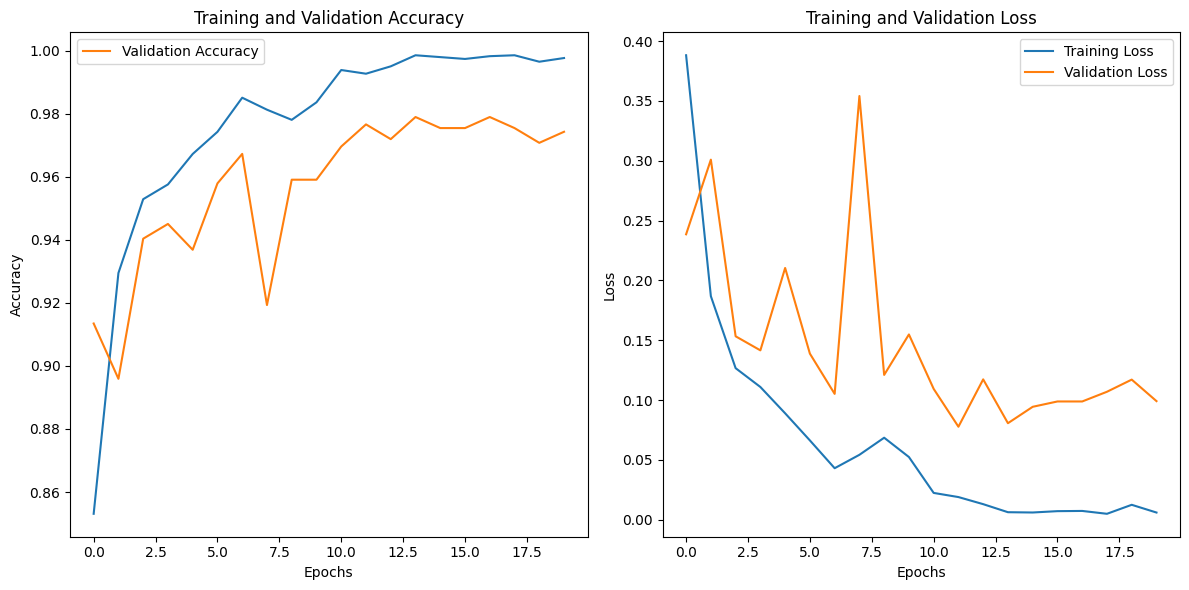

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
model.evaluate(validation_generator)

27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 904ms/step - accuracy: 0.9685 - loss: 0.1253


[0.080660879611969, 0.9789473414421082]